# Homework 4 - time series forecasting

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Dataset preparation

In [15]:
data = pd.read_csv('wisla.csv')
data.head()

,stationid,name,water,hyear,hmonth,day,level,month
0,149180140,WISŁA,Wisła (2),1981,1,1,114,11
1,149180140,WISŁA,Wisła (2),1981,1,2,114,11
2,149180140,WISŁA,Wisła (2),1981,1,3,114,11
3,149180140,WISŁA,Wisła (2),1981,1,4,114,11
4,149180140,WISŁA,Wisła (2),1981,1,5,113,11


I combine the year, month and day of the measurment into one feature `date`, which will simplify the futher modelling.

In [17]:
data.rename(columns={'hyear': 'year'}, inplace=True)
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

I decided to investigate the monthly time-series forecasting, therefore for each month I extract the mean value of the water level in Vistula river.

In [ ]:
df = data[['date', 'level']].set_index('date')
monthly_df = df.resample('M').mean()

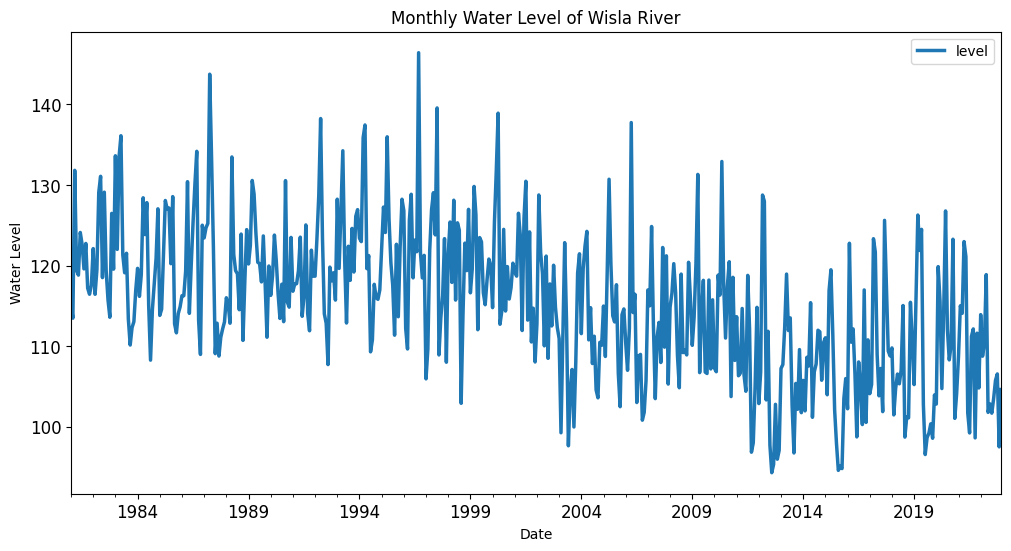

In [31]:
monthly_df.plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Monthly Water Level of Wisla River')
plt.show()

# Trend and seasonality

## Additive model

In the additive model, the time series (Y) is assumed to be the sum of the three components:
$Y = T + S + R$
where:

1. Y is the observed time series value
2. T is the trend component and it represents the long-term pattern or direction of the time series. 
3. S is the seasonality component, which captures the regular, periodic fluctuations in the time series
5. R is the residual component and represents the remaining part of the time series after removing the trend and seasonality, capturing random fluctuations

In [52]:
series = pd.Series(monthly_df['level'], index=monthly_df.index)
result = seasonal_decompose(series, model='additive')

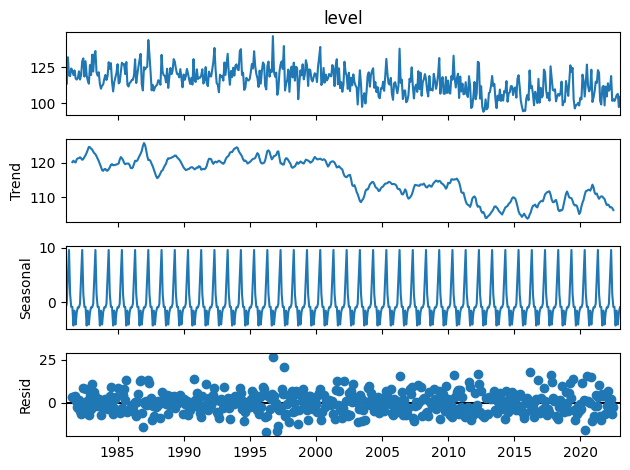

In [60]:
result.plot()
plt.show()

1. Trend: Over the period from 1981 to 2024, there is a definite decreasing trend observed in the water levels. Theobservation is validated by examining the 12-month rolling mean of the water level data, which shows a clear downward trajectory when calculated over the moving window of 12 months.

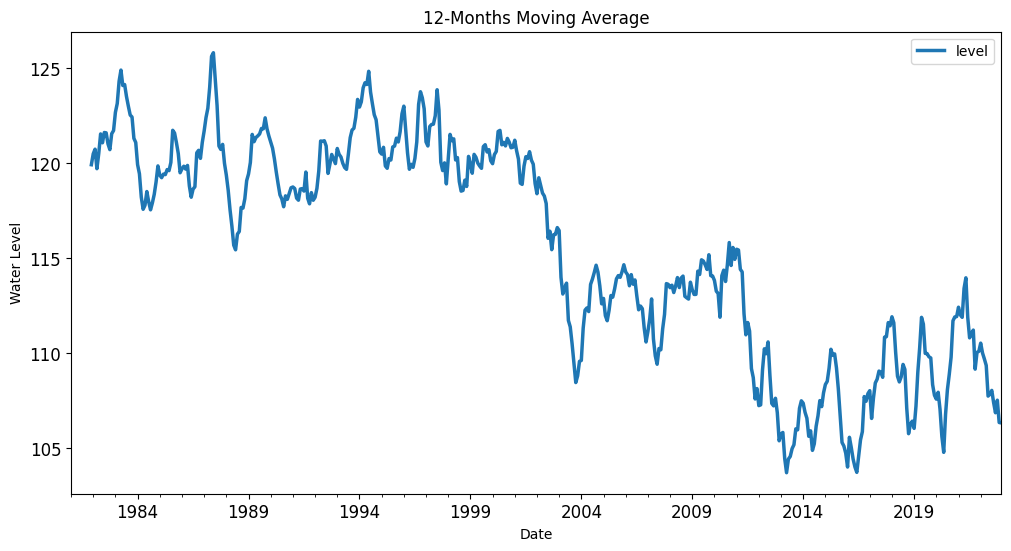

In [57]:
monthly_df.rolling(window=12).mean().plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.title('12-Months Moving Average')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.show()

2. Seasonality: We can notice that the additive model identified some regularities within 12-month time intervals, which overall makes a lot of sense, as they fit into the natural annual cycle.
I further investigate the seasonality factor, looking closer at years 2010-2011. As we can see, the biggest spike appears in April, when the winter snows melt and the potential of high water level in river is 

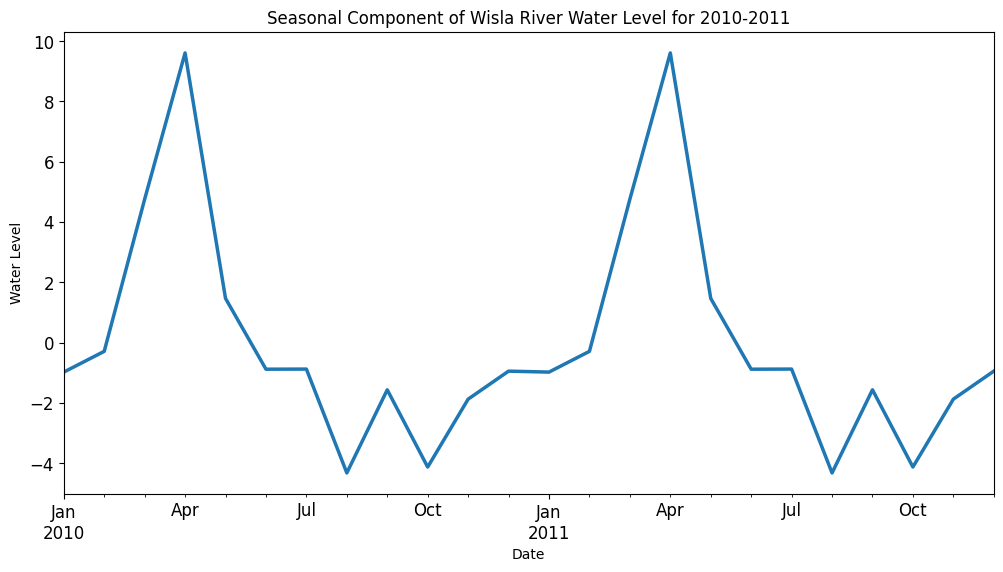

In [63]:
result.seasonal['2010-01-31':'2011-12-31'].plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.title('Seasonal Component of Wisla River Water Level for 2010-2011')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.show()

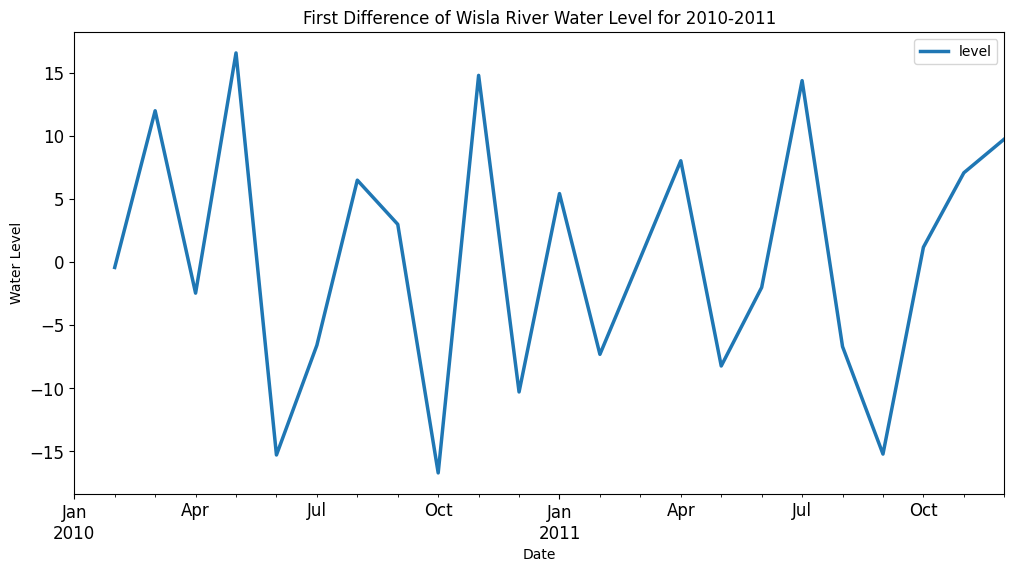

In [66]:
monthly_df['2010':'2011'].diff().plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.title('First Difference of Wisla River Water Level for 2010-2011')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.show()

# Stationarity

## Augmented Dickey-Fuller test

In [67]:
result = adfuller(monthly_df['level'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.338098
p-value: 0.611567
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


Based on the p-value of the ADF test we should not reject the null hypothesis. Therefore it is likely that this time series is non-stationary. I validate this finding by looking at complementary KPSS test.

## Kwiatkowski-Phillips-Schmidt-Shin test

In [87]:
result = kpss(monthly_df['level'].dropna(), regression='c', nlags='auto')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 3.619952
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\jan20\AppData\Local\Temp\ipykernel_16572\3663233560.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(monthly_df['level'].dropna(), regression='c', nlags='auto')


 Unlike the ADF test, which has a null hypothesis of non-stationarity, the KPSS test has a null hypothesis of stationarity. P-value is lesser than 0.05 indicating that indeed, the time-series related to water level in vistula river is not stationary.

# Autocorrelation

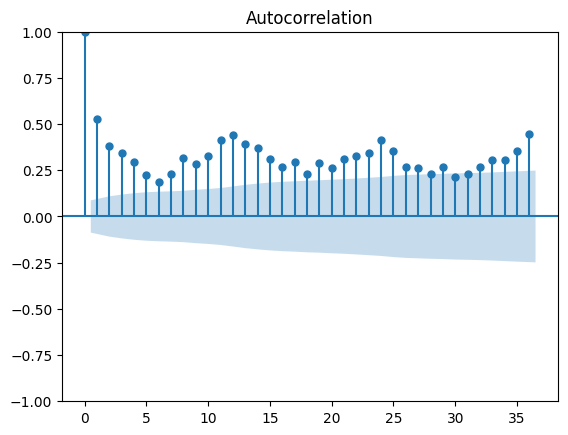

In [85]:
acf_plot = plot_acf(monthly_df['level'], lags=36)

# ARIMA model

In previous section I discussed the non-stationarity of the Vistula river water level time-series. Therefore, I decided to use the ARIMA model instead of ARMA model, as it can handle non-stationary time series data.

In [99]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

ts_data = monthly_df['level']

I decided to split the dataset into 3 parts:
1. Training: 70%
2. Validation: 15%
3. Testing: 15%

In [102]:
train_size = int(len(ts_data) * 0.7)
val_size = int(len(ts_data) * 0.15)   
test_size = len(ts_data) - train_size - val_size

train_data, val_data, test_data = ts_data[0:train_size], ts_data[train_size:train_size+val_size], ts_data[-test_size:]

# Train and validate models
best_rmse = np.inf
best_model = None
best_params = None

# Define ranges for p, d, and q
p_values = [0, 2, 4, 8, 12]
d_values = [0, 1, 2]
q_values = [0, 2, 4, 8, 12]

I also define the grid of values for `p`, `d` and `q` - parameters of ARIMA model.
1. `p` - autoregressive order (AR), which specifies number of lags used as predictors
2. `d` - the integrated order (I), representing the number of times needed to difference time series to get stationary process
3. `q` - the moving average order (MA), specifing number of lagged errorrs used as predictors in the model. 

In [117]:
p_values = [0, 2, 6, 12, 24]
d_values = [0, 1, 2, 4]
q_values = [0, 2, 6, 12, 24]

In order to find the optimal model, I perform the grid search. In advance I suspect that the `p` might be a multiple of 12, while `d` should be at least equal to 1 (as $d=0$ would imply stationarity of process, which we assessed as not true).

In [118]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            model = ARIMA(train_data, order=(p, d, q))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(val_data))
            rmse = np.sqrt(mean_squared_error(val_data, y_pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model_fit
                best_params = (p, d, q)


In [104]:
print("Best Parameters:", best_params)
print("Best RMSE on Validation Set:", best_rmse)

Best Parameters: (12, 2, 0)
Best RMSE on Validation Set: 8.252670692211167
RMSE on Test Set (using best model): 8.473146513781481


## Results

In [ ]:
best_model = ARIMA(ts_data, order=best_params)
best_model_fit = best_model.fit()

forecast_steps = len(test_data)
observed_values = ts_data[:len(train_data)+len(val_data)].copy()

forecast_values = []
for i in range(forecast_steps):
    forecast = best_model_fit.forecast(steps=1)
    forecast_values.append(forecast[0])
    observed_values = observed_values.append(ts_data[len(train_data)+len(val_data)+i:i+1])

plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data, label='Actual Data', color='blue')
plt.plot(observed_values.index, observed_values, label='Observed Values', color='green')
plt.plot(ts_data.index[-forecast_steps:], forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

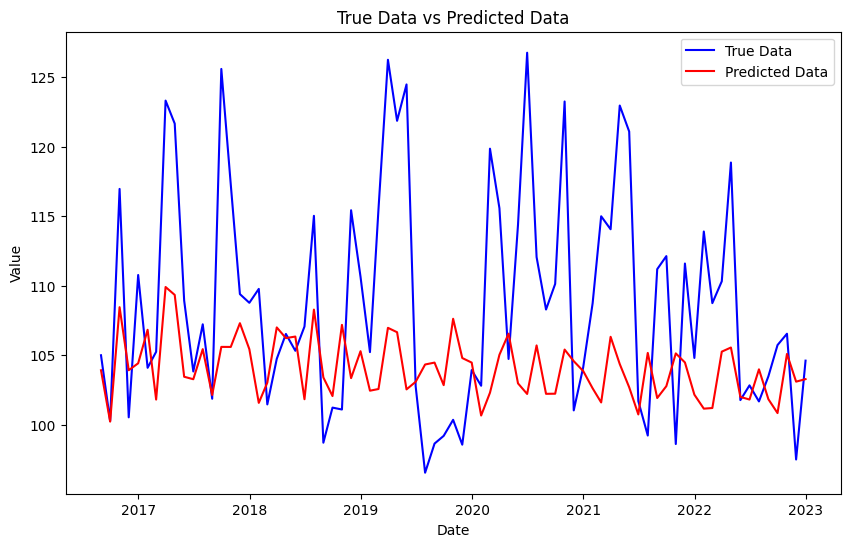

In [115]:
steps = len(test_data)
# combine train and val data
train_data = ts_data[:train_size+val_size]
model = ARIMA(train_data, order=best_params)
model_fit = model.fit()
# Generate the forecast
forecast = model_fit.forecast(steps=steps)

# Create a new plot
plt.figure(figsize=(10, 6))

plt.plot(test_data.index, test_data, label='True Data', color='blue')

# Plot the predicted data
plt.plot(test_data.index, forecast, label='Predicted Data', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('True Data vs Predicted Data')

# Add a legend
plt.legend()

# Show the plot
plt.show()

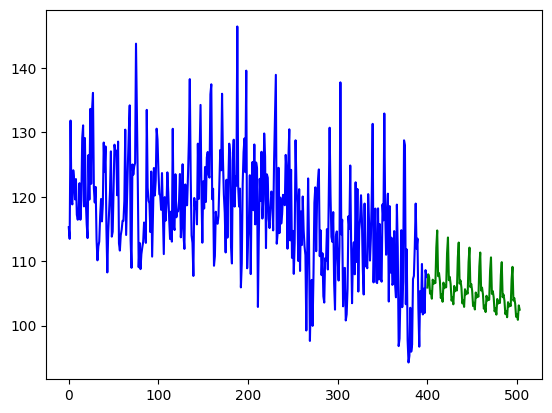

In [91]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = monthly_df['level']
train, test = train_test_split(y, train_size=400)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:train.shape[0]], train, c='blue')
plt.plot(x[train.shape[0]:], forecasts, c='green')
plt.show()

In [89]:
model.order

(1, 1, 1)

In [88]:
order = model.order

# Unpack the orders
p, d, q, P, D, Q, m = order

# Print the non-seasonal orders
print(f"Non-seasonal orders: p={p}, d={d}, q={q}")

ValueError: not enough values to unpack (expected 7, got 3)